https://www.statsmodels.org/stable/vector_ar.html

In [25]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import statsmodels.api as sm
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [26]:
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[["year", "quarter"]].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

mdata = mdata[["realgdp", "realcons", "realinv"]]

mdata.index = pd.DatetimeIndex(quarterly, freq="QE")

data = np.log(mdata).diff().dropna()

data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


In [27]:
var_model = VAR(data)

var_results = var_model.fit(maxlags=2)

var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     23:01:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

In [28]:
y = jnp.array(data)

In [29]:
n_vars = data.shape[1]
n_lags = 2

phi = jnp.arange(n_lags * n_vars * n_vars).reshape(n_lags, n_vars, n_vars)

phi

Array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]], dtype=int32)

In [30]:
y_lags = 2 * jnp.ones((n_lags, n_vars))

y_lags

Array([[2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

In [32]:
(phi * y_lags[..., jnp.newaxis]).sum(axis=(0, 2))

Array([ 66., 102., 138.], dtype=float32)

In [ ]:
jnp.einsum("lij,lj->i", phi, y_lags)

Array([ 66., 102., 138.], dtype=float32)

In [51]:
def model(
    y: Float[Array, "time vars"], n_lags: int
) -> Float[Array, "time_minus_n_lags vars"]:
    n_time, n_vars = y.shape

    constant = numpyro.sample("constant", dist.Normal(0, 1).expand([n_vars]))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0).expand([n_vars]))

    l_omega = numpyro.sample(
        "l_omega", dist.LKJCholesky(dimension=n_vars, concentration=1.0)
    )
    l_sigma = jnp.einsum("...i,...ij->...ij", sigma, l_omega)

    # Sample phi coefficients - shape (n_lags, n_vars, n_vars)
    phi = numpyro.sample(
        "phi", dist.Normal(0, 10).expand([n_lags, n_vars, n_vars]).to_event(3)
    )

    def transition(carry, _):
        # carry: (n_lags, n_vars)
        y_lags = carry

        # Compute VAR mean
        lag_contributions = jnp.einsum("lij,lj->i", phi, y_lags)
        m_t = constant + lag_contributions

        # Sample observation
        y_t = numpyro.sample(
            "y_pred", dist.MultivariateNormal(loc=m_t, scale_tril=l_sigma)
        )

        # Update carry: remove oldest, add newest
        new_carry = jnp.concatenate([y_lags[1:], y_t[None, :]], axis=0)
        return new_carry, y_t

    # Initialize and run scan
    init_carry = y[:n_lags]
    time_indices = jnp.arange(n_lags, n_time)

    with condition(data={"y_pred": y[n_lags:]}):
        _, y_pred = scan(transition, init=init_carry, xs=time_indices)

    return y_pred

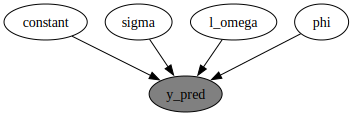

In [52]:
numpyro.render_model(model, model_kwargs={"y": y, "n_lags": 2})

In [18]:
%%time

nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

# Run inference
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, y=y, n_lags=2)

# Get samples
samples = mcmc.get_samples()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 2min 1s, sys: 1.5 s, total: 2min 3s
Wall time: 32.9 s


In [19]:
idata = az.from_numpyro(
    mcmc,
    coords={"var_1": data.columns, "var_2": data.columns, "lag": range(2, 0, -1)},
    dims={
        "constant": ["vars"],
        "sigma": ["vars"],
        "l_omega": ["var_1", "var_2"],
        "phi": ["lag", "var_1", "var_2"],
    },
)

In [20]:
idata["posterior"]["phi"].mean(dim=["chain", "draw"]).sel(var_1="realgdp", lag=1)

<xarray.DataArray 'phi' (var_2: 3)> Size: 12B
array([-0.2730976 ,  0.6722672 ,  0.03255958], dtype=float32)
Coordinates:
    var_1    <U7 28B 'realgdp'
  * var_2    (var_2) object 24B 'realgdp' 'realcons' 'realinv'
    lag      int64 8B 1

In [21]:
a = idata["posterior"]["l_omega"].mean(dim=["chain", "draw"])

In [22]:
corr = a.to_numpy() @ a.to_numpy().T
corr

array([[1.        , 0.5968012 , 0.7465129 ],
       [0.5968012 , 0.9967926 , 0.1239324 ],
       [0.7465129 , 0.1239324 , 0.99647546]], dtype=float32)

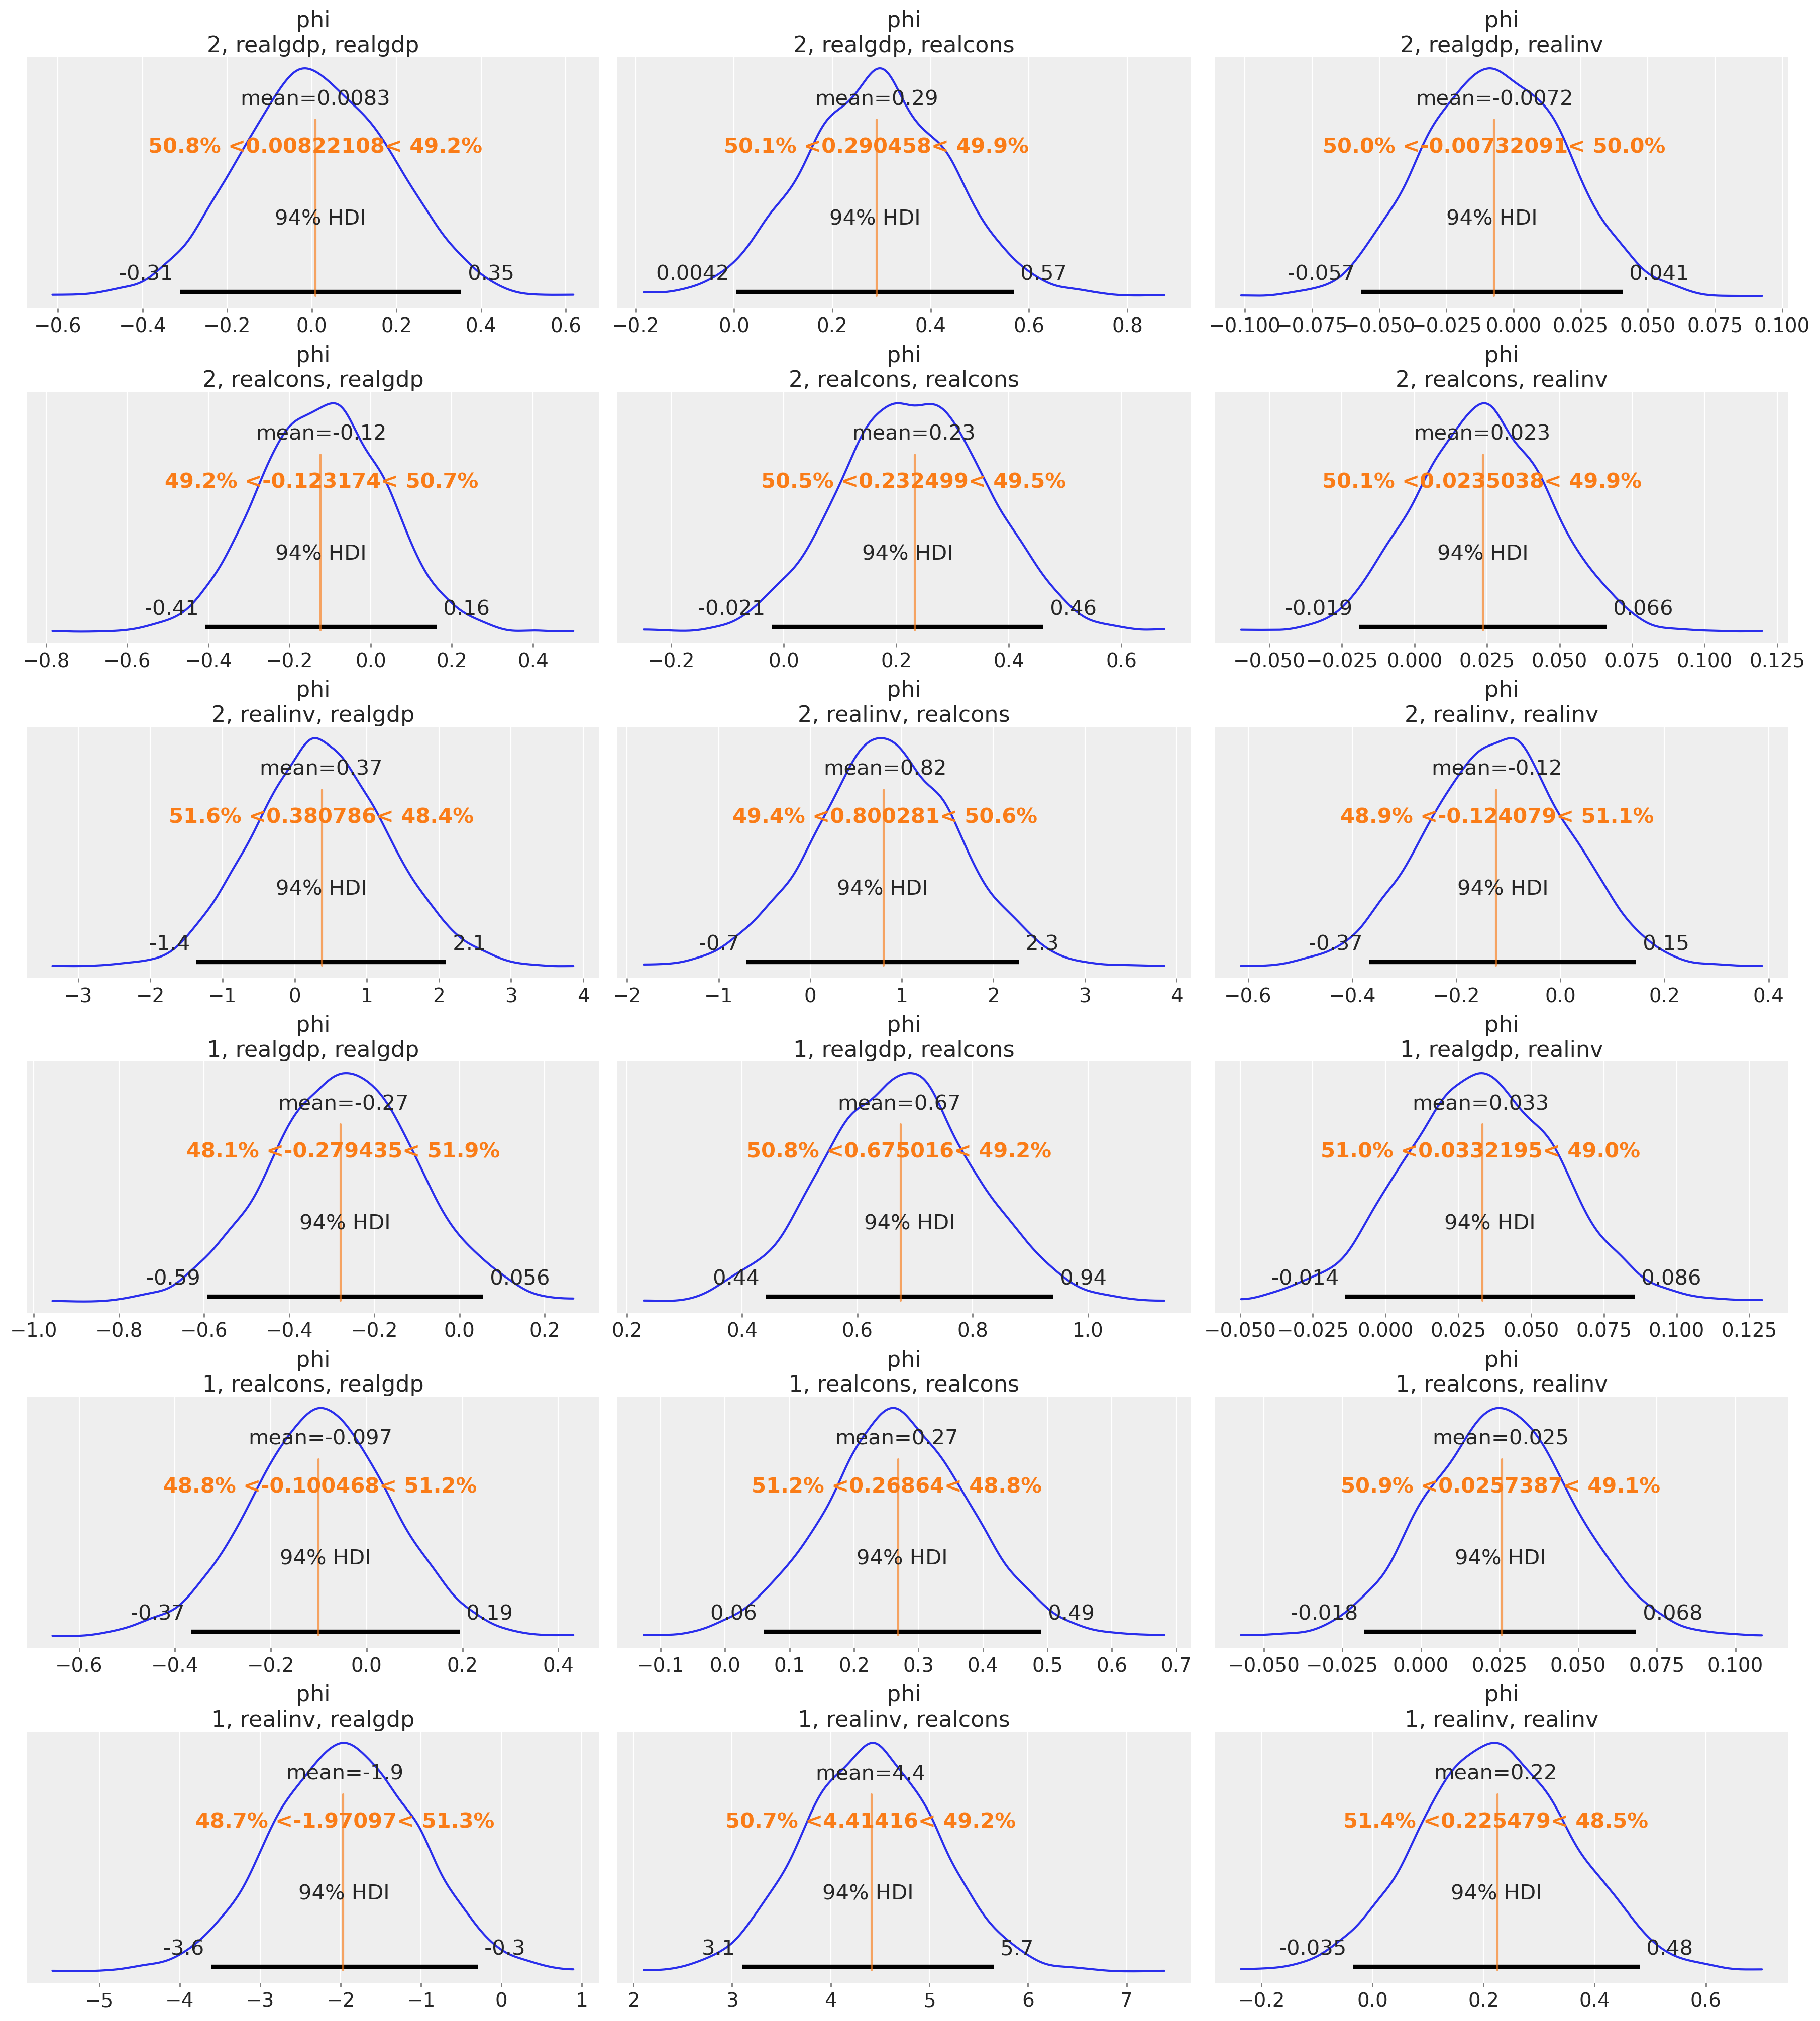

In [50]:
# Reference values from statsmodels VAR(2) results
# Simplified construction using list comprehension and f-strings
lags = [1, 2]
variables = ["realgdp", "realcons", "realinv"]

ref_vals_phi = {
    "phi": [
        {
            "lag": lag,
            "var_1": var_1,
            "var_2": var_2,
            "ref_val": var_results.params[var_1][f"L{lag}.{var_2}"],
        }
        for lag in lags
        for var_1 in variables
        for var_2 in variables
    ]
}

az.plot_posterior(idata, var_names=["phi"], ref_val=ref_vals_phi, figsize=(18, 20));